In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/animefacedataset/images/35715_2011.jpg
/kaggle/input/animefacedataset/images/48610_2014.jpg
/kaggle/input/animefacedataset/images/34719_2011.jpg
/kaggle/input/animefacedataset/images/40266_2012.jpg
/kaggle/input/animefacedataset/images/4199_2002.jpg
/kaggle/input/animefacedataset/images/40739_2013.jpg
/kaggle/input/animefacedataset/images/42515_2013.jpg
/kaggle/input/animefacedataset/images/52482_2015.jpg
/kaggle/input/animefacedataset/images/46555_2014.jpg
/kaggle/input/animefacedataset/images/11579_2005.jpg
/kaggle/input/animefacedataset/images/36943_2012.jpg
/kaggle/input/animefacedataset/images/9787_2004.jpg
/kaggle/input/animefacedataset/images/3388_2002.jpg
/kaggle/input/animefacedataset/images/8393_2004.jpg
/kaggle/input/animefacedataset/images/30352_2010.jpg
/kaggle/input/animefacedataset/images/10908_2005.jpg
/kaggle/input/animefacedataset/images/22363_2008.jpg
/kaggle/input/animefacedataset/images/51151_2015.jpg
/kaggle/input/animefacedataset/images/59491_2018.j

In [2]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [3]:
!pip install pytorch-ignite

In [4]:
import torch
import torchvision
import ignite

print(*map(lambda m: ": ".join((m.__name__, m.__version__)), (torch, torchvision, ignite)), sep="\n")

torch: 2.0.0
torchvision: 0.15.1
ignite: 0.4.13


In [6]:
!pip install torchsummary
import os
import logging
import matplotlib.pyplot as plt

import numpy as np

from torchsummary import summary

import torch
import torch.nn as nn
import torch.optim as optim

import torchvision.transforms as transforms
import torchvision.utils as vutils

from ignite.engine import Engine, Events
import ignite.distributed as idist

In [7]:
ignite.utils.manual_seed(999)
ignite.utils.setup_logger(name="ignite.distributed.auto.auto_dataloader", level=logging.WARNING)
ignite.utils.setup_logger(name="ignite.distributed.launcher.Parallel", level=logging.WARNING)

<_Logger ignite.distributed.launcher.Parallel (WARNING)>

In [8]:
from torchvision.datasets import ImageFolder
image_size = 64

data_transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_dataset = ImageFolder(root="/kaggle/input", transform=data_transform)
test_dataset = torch.utils.data.Subset(train_dataset, torch.arange(3000))

In [9]:
batch_size = 128

train_dataloader = idist.auto_dataloader(
    train_dataset, 
    batch_size=batch_size, 
    num_workers=2, 
    shuffle=True, 
    drop_last=True,
)

test_dataloader = idist.auto_dataloader(
    test_dataset, 
    batch_size=batch_size, 
    num_workers=2, 
    shuffle=False, 
    drop_last=True,
)


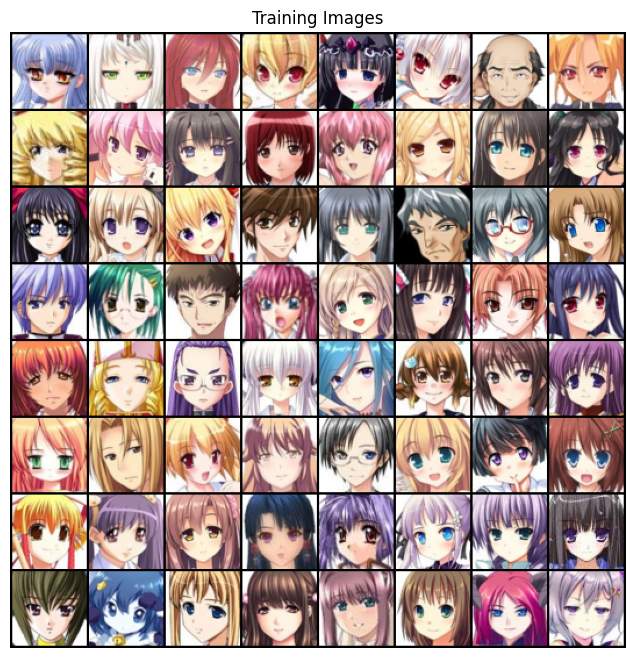

In [10]:
real_batch = next(iter(train_dataloader))

plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [32]:
# Defining Variables:
# Number of GPUs available We would use 0 for CPU mode.
ngpu = 1
# Size of feature maps in discriminator
ndf = 64
# Number of channels in the training images. For color images this is 3
nc = 3
#  latent space dimension of input vectors for the generator
latent_dim = 100
'''
For number of epochs we start we atleast 25 to check out the result and keep on incresing
this value.
'''
# Number of training epochs
num_epochs = 50 

# Learning rates
'''
Learning rate for optimizers is preferred to be selected to be very low, good to go
with 0.0002 or we may select even smaller value but it may result in computational cost.
'''
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

In [33]:
#Generator
'''
>   This model is motivated from the research paper from:
    https://arxiv.org/abs/1511.06434
    UNSUPERVISED REPRESENTATION LEARNING
    WITH DEEP CONVOLUTIONAL
    GENERATIVE ADVERSARIAL NETWORKS
    2016

>   The generator gradually upsamples the input noise through a series of transposed
    convolutional layers with batch normalization and ReLU activation until the final
    layer produces an output tensor with the same dimensions as the target images
    (64x64 in this case).
    
> Please refer to the research paper page 3-4.

> We have reduced the model architecture (in the research paper) starting from 1024
channels to 512 channels to take in account for the computational costs.
'''

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            #for refernce:
            #nn.ConvTranspose2d(in_channels, out_channels, kernel_size, stride, padding, bias)
            # input is Z, going into a convolution
            
         # Input: 1x1x100, Output: 4x4x512
            nn.ConvTranspose2d(in_channels=100, out_channels=512, kernel_size=4, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
            # Input: 4x4x512, Output: 8x8x256
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            
            # Input: 8x8x256, Output: 16x16x128
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            
            # Input: 16x16x128, Output: 32x32x64
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            
            # Input: 32x32x64, Output: 64x64x3
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()  # Tanh activation function to map values to the image pixel range (e.g., [-1, 1]).
        )

    def forward(self, input):
        return self.main(input)

#### Explainantion for the Generator network:
- We use TransposeConv2d for upsampling the input.
- We select the Size of feature maps in generator and the Size of feature maps in discriminatoras 64 to both, because larger this value more potentially allow the model to capture more complex features but may require more computational resources. We might had selescted 32 or less but it may give poor result. Therefore we select 64 as a good point to start with.
- A larger latent vector might allow the generator to capture more intricate patterns. Therefore we select it to be 100.


- The generator has an input of a 1x1x100 vector, and the wanted output is a 3x64x64.
- We have the formula to evaluate the output size:
$$n_{\text{out}} = (n_{\text{in}} -1)\times s - 2p + (k-1) +1$$

```
# The first layer:
nn.ConvTranspose2d( in_channels=100, out_channels=512, 
                               kernel_size=4, stride=1, padding=0,bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            
```
$$n_{\text{out}} = (1-1)\times 1 - 2\times 0 + (4-1) +1  = 4$$

- The output size of the transposed convolution is 4x4, as indicated in the code.

- The next four convolutional layers are identical with a kernel size of four, a stride of two and a padding of one. This doubles the size of each input. So 4x4 turns to 8x8, then 16x16, 32x32 and finally, 64x64.

- **Batch normalization** standardizes the activations from a prior layer to have a zero mean and unit variance. This has the effect of stabilizing the training process.

- **Activation function ReLU** is used to address the vanishing gradient problem in deep convolutional neural networks and promote sparse activations (e.g. lots of zero values).

In [34]:
netG = idist.auto_model(Generator(latent_dim))
idist.device()
summary(netG, (latent_dim, 1, 1))

2024-01-18 15:57:41,178 ignite.distributed.auto.auto_model INFO: Apply torch DataParallel on model


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ConvTranspose2d-1            [-1, 512, 4, 4]         819,200
   ConvTranspose2d-2            [-1, 512, 4, 4]         819,200
       BatchNorm2d-3            [-1, 512, 4, 4]           1,024
       BatchNorm2d-4            [-1, 512, 4, 4]           1,024
              ReLU-5            [-1, 512, 4, 4]               0
   ConvTranspose2d-6            [-1, 256, 8, 8]       2,097,152
              ReLU-7            [-1, 512, 4, 4]               0
   ConvTranspose2d-8            [-1, 256, 8, 8]       2,097,152
       BatchNorm2d-9            [-1, 256, 8, 8]             512
      BatchNorm2d-10            [-1, 256, 8, 8]             512
             ReLU-11            [-1, 256, 8, 8]               0
             ReLU-12            [-1, 256, 8, 8]               0
  ConvTranspose2d-13          [-1, 128, 16, 16]         524,288
  ConvTranspose2d-14          [-1, 128,

In [35]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            
            # Input: 64x64x3, Output: 32x32x64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Input: 32x32x64, Output: 16x16x128
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Input: 16x16x128, Output: 8x8x256
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Input: 8x8x256, Output: 4x4x512
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            
            # Input: 4x4x512, Output: 1x1x1
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()  # Sigmoid activation to map the output to a probability (0 to 1)
        )

    def forward(self, input):
        return self.main(input)


#### Explainantion for the Discriminator network:
- We use Conv2d for downsampling the input (i.e. the output generated by the generator.).
- The input size to the discriminator is a 3x64x64 image, the output size is a binary 1x1 scalar. 
- We have the formula to evaluate the output size:

$$
n_{\text{out}} = \frac{{(n_{\text{in}} + 2p - k)}}{s} + 1
$$


```
# The first layer:
# Input: 64x64x3, Output: 32x32x64
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),            
```
$$n_{\text{out}} = \frac{64 + 2\times1 - 4}{2} + 1 = 32$$
- The output size of the transposed convolution is 4x4, as indicated in the code.

- The next four convolutional layers are identical with a kernel size of four, a stride of two and a padding of one. This doubles the size of each input. So 4x4 turns to 8x8, then 16x16, 32x32 and finally, 64x64.

#### Why using the leaky relu?
- Leaky ReLU (Rectified Linear Unit) is a type of activation function that allows a small, non-zero gradient when the input is negative. It is defined as:

$$
\text{Leaky ReLU}(x) = \begin{cases} 
x & \text{if } x > 0 \\
\text{negative\_slope} \times x & \text{otherwise}
\end{cases}
$$
- ReLU is recommended for the generator, but not for the discriminator model. Instead, a variation of ReLU that allows values less than zero, called Leaky ReLU, is preferred in the discriminator.


In [36]:
ngpu = 1
netD = idist.auto_model(Discriminator(ngpu))
summary(netD, (3, 64, 64))


2024-01-18 15:57:41,765 ignite.distributed.auto.auto_model INFO: Apply torch DataParallel on model


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           3,072
            Conv2d-2           [-1, 64, 32, 32]           3,072
         LeakyReLU-3           [-1, 64, 32, 32]               0
         LeakyReLU-4           [-1, 64, 32, 32]               0
            Conv2d-5          [-1, 128, 16, 16]         131,072
            Conv2d-6          [-1, 128, 16, 16]         131,072
       BatchNorm2d-7          [-1, 128, 16, 16]             256
       BatchNorm2d-8          [-1, 128, 16, 16]             256
         LeakyReLU-9          [-1, 128, 16, 16]               0
        LeakyReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11            [-1, 256, 8, 8]         524,288
           Conv2d-12            [-1, 256, 8, 8]         524,288
      BatchNorm2d-13            [-1, 256, 8, 8]             512
      BatchNorm2d-14            [-1, 25

In [37]:
#Loss functions and Optimizers
# Initialize BCELoss function
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, latent_dim, 1, 1, device=idist.device())
'''
fixed_noise is a 4-dimensional tensor with a shape of (64, 100, 1, 1). Each of the
64 samples has 100 values, and the spatial dimensions are 1x1.
'''


# Setup Adam optimizers for both G and D
'''
Additionally, we found leaving the momentum term β1 at the suggested value of 0.9
resulted in training oscillation and instability while reducing it to 0.5 helped
stabilize training.
'''
optimizerD = idist.auto_optim(
    optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
)

optimizerG = idist.auto_optim(
    optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))
)

In [38]:
# Establish convention for real and fake labels during training
real_label = 1
fake_label = 0


def training_step(engine, data):
    # Set the models for training
    netG.train()
    netD.train()

    ############################
    # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
    ###########################
    ## Train with all-real batch
    netD.zero_grad()
    # Format batch
    real = data[0].to(idist.device())
    b_size = real.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device=idist.device())
    # Forward pass real batch through D
    output1 = netD(real).view(-1)
    # Calculate loss on all-real batch
    errD_real = criterion(output1, label)
    # Calculate gradients for D in backward pass
    errD_real.backward()

    ## Train with all-fake batch
    # Generate batch of latent vectors
    noise = torch.randn(b_size, latent_dim, 1, 1, device=idist.device())
    # Generate fake image batch with G
    fake = netG(noise)
    label.fill_(fake_label)
    # Classify all fake batch with D
    output2 = netD(fake.detach()).view(-1)
    # Calculate D's loss on the all-fake batch
    errD_fake = criterion(output2, label)
    # Calculate the gradients for this batch, accumulated (summed) with previous gradients
    errD_fake.backward()
    # Compute error of D as sum over the fake and the real batches
    errD = errD_real + errD_fake
    # Update D
    optimizerD.step()

    ############################
    # (2) Update G network: maximize log(D(G(z)))
    ###########################
    netG.zero_grad()
    label.fill_(real_label)  # fake labels are real for generator cost
    # Since we just updated D, perform another forward pass of all-fake batch through D
    output3 = netD(fake).view(-1)
    # Calculate G's loss based on this output
    errG = criterion(output3, label)
    # Calculate gradients for G
    errG.backward()
    # Update G
    optimizerG.step()

    return {
        "Loss_G" : errG.item(),
        "Loss_D" : errD.item(),
        "D_x": output1.mean().item(),
        "D_G_z1": output2.mean().item(),
        "D_G_z2": output3.mean().item(),
    }

In [39]:
trainer = Engine(training_step)

def initialize_fn(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

@trainer.on(Events.STARTED)
def init_weights():
    netD.apply(initialize_fn)
    netG.apply(initialize_fn)

@trainer.on(Events.STARTED)
def init_weights():
    netD.apply(initialize_fn)
    netG.apply(initialize_fn)
    

G_losses = []
D_losses = []


@trainer.on(Events.ITERATION_COMPLETED)
def store_losses(engine):
    o = engine.state.output
    G_losses.append(o["Loss_G"])
    D_losses.append(o["Loss_D"])
    

img_list = []
@trainer.on(Events.ITERATION_COMPLETED(every=500))
def store_images(engine):
    with torch.no_grad():
        fake = netG(fixed_noise).cpu()
    img_list.append(fake)



In [40]:
from ignite.metrics import FID, InceptionScore
fid_metric = FID(device=idist.device())
is_metric = InceptionScore(device=idist.device(), output_transform=lambda x: x[0])
import PIL.Image as Image


def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)


def evaluation_step(engine, batch):
    with torch.no_grad():
        noise = torch.randn(batch_size, latent_dim, 1, 1, device=idist.device())
        netG.eval()
        fake_batch = netG(noise)
        fake = interpolate(fake_batch)
        real = interpolate(batch[0])
        return fake, real


In [41]:
evaluator = Engine(evaluation_step)
fid_metric.attach(evaluator, "fid")
is_metric.attach(evaluator, "is")

In [42]:
fid_values = []
is_values = []


@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(test_dataloader,max_epochs=1)
    metrics = evaluator.state.metrics
    fid_score = metrics['fid']
    is_score = metrics['is']
    fid_values.append(fid_score)
    is_values.append(is_score)
    print(f"Epoch [{engine.state.epoch}/5] Metric Scores")
    print(f"*   FID : {fid_score:4f}")
    print(f"*    IS : {is_score:4f}")


In [43]:
from ignite.metrics import RunningAverage
RunningAverage(output_transform=lambda x: x["Loss_G"]).attach(trainer, 'Loss_G')
RunningAverage(output_transform=lambda x: x["Loss_D"]).attach(trainer, 'Loss_D')

In [44]:
from ignite.contrib.handlers import ProgressBar
ProgressBar().attach(trainer, metric_names=['Loss_G','Loss_D'])
ProgressBar().attach(evaluator)


In [45]:
def training(*args):
    trainer.run(train_dataloader, max_epochs=25)

with idist.Parallel(backend='gloo') as parallel:
    parallel.run(training)

[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [1/5] Metric Scores
*   FID : 0.087463
*    IS : 1.334385


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [2/5] Metric Scores
*   FID : 0.060341
*    IS : 1.488454


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [3/5] Metric Scores
*   FID : 0.055893
*    IS : 1.481468


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [4/5] Metric Scores
*   FID : 0.048465
*    IS : 1.648538


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [5/5] Metric Scores
*   FID : 0.045903
*    IS : 1.752991


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [6/5] Metric Scores
*   FID : 0.036976
*    IS : 1.783461


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [7/5] Metric Scores
*   FID : 0.047239
*    IS : 1.971122


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [8/5] Metric Scores
*   FID : 0.052337
*    IS : 1.848440


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [9/5] Metric Scores
*   FID : 0.033870
*    IS : 2.043438


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [10/5] Metric Scores
*   FID : 0.031575
*    IS : 1.904419


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [11/5] Metric Scores
*   FID : 0.032468
*    IS : 1.881769


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [12/5] Metric Scores
*   FID : 0.046661
*    IS : 1.929416


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [13/5] Metric Scores
*   FID : 0.034976
*    IS : 1.813596


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [14/5] Metric Scores
*   FID : 0.037280
*    IS : 1.883625


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [15/5] Metric Scores
*   FID : 0.037869
*    IS : 1.804439


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [16/5] Metric Scores
*   FID : 0.034242
*    IS : 1.905176


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [17/5] Metric Scores
*   FID : 0.044218
*    IS : 1.874496


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [18/5] Metric Scores
*   FID : 0.030828
*    IS : 1.844852


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [19/5] Metric Scores
*   FID : 0.034224
*    IS : 1.938397


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [20/5] Metric Scores
*   FID : 0.026526
*    IS : 1.854676


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [21/5] Metric Scores
*   FID : 0.022502
*    IS : 1.842829


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [22/5] Metric Scores
*   FID : 0.030016
*    IS : 1.882623


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [23/5] Metric Scores
*   FID : 0.030149
*    IS : 1.920386


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [24/5] Metric Scores
*   FID : 0.034619
*    IS : 1.899339


[1/496]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [25/5] Metric Scores
*   FID : 0.021579
*    IS : 1.875565


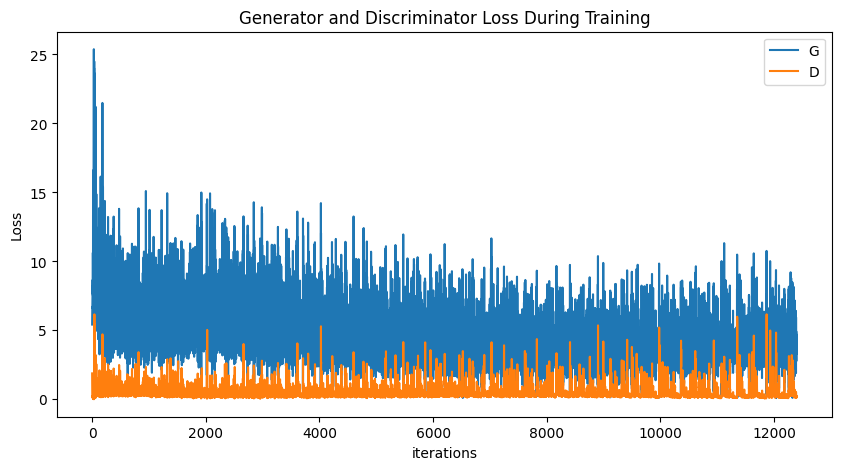

In [46]:
%matplotlib inline

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.savefig("loss_plot_epoch25.png")



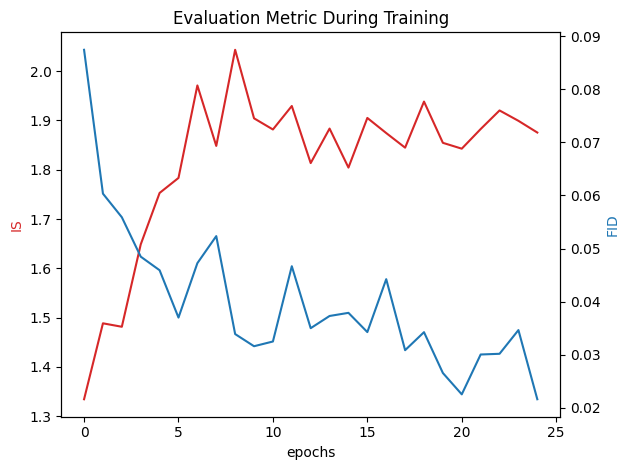

In [47]:
fig, ax1 = plt.subplots()

plt.title("Evaluation Metric During Training")

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('IS', color=color)
ax1.plot(is_values, color=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('FID', color=color)
ax2.plot(fid_values, color=color)

fig.tight_layout()
plt.savefig("FID and IS for 25 epoch.png")


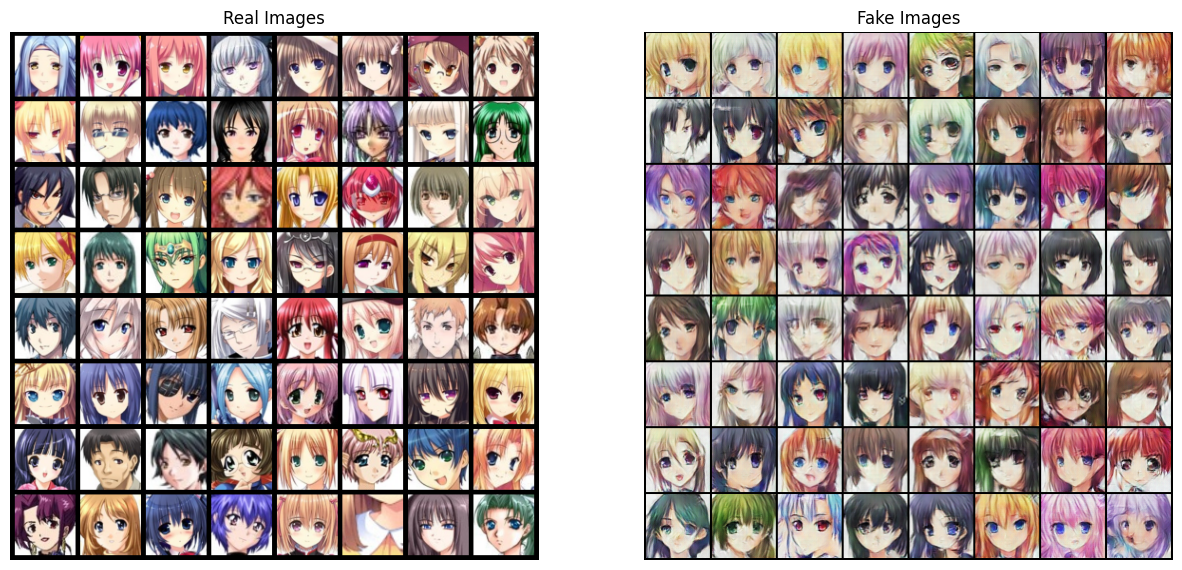

In [48]:
%matplotlib inline

# Grab a batch of real images from the dataloader
real_batch = next(iter(train_dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(img_list[-1], padding=2, normalize=True).cpu(),(1,2,0)))
plt.savefig("Real Vs Fake at 25 Epoch.png")
